In [1]:
!pip install -q  torch bitsandbytes==0.41.3 trl==0.4.7 accelerate
!pip install git+https://github.com/huggingface/transformers.git git+https://github.com/huggingface/peft.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.7 MB/s eta 0:00:00
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-u1e4e7gn
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-u1e4e7gn
  Resolved https://github.com/huggingface/transformers.git to commit f386c51ad9034bae4d3ce6b5820b97796ff7f8a1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/huggingface/p

In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
!apt install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [4]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.39.0.dev0', '0.27.2')

In [5]:
from transformers.utils import send_example_telemetry

send_example_telemetry("language_modeling_from_scratch_notebook", framework="pytorch")
from datasets import load_dataset

In [6]:
import pandas as pd

import random

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('/content/dataset_cleaned.csv')

# Randomly select 50 rows from the DataFrame
selected_rows = df.sample(50)

# Write the selected rows to a new CSV file
selected_rows.to_csv('/content/dataset_cleaned_val.csv', index=False)
# Get the indices of the randomly sampled rows
sampled_indices = selected_rows.index.tolist()

# Drop the sampled rows from the original DataFrame
df_no_sampled = df.drop(sampled_indices)

# Write the updated DataFrame to a new CSV file
df_no_sampled.to_csv('/content/dataset_cleaned_val_no_sampled.csv', index=False)

In [7]:
datasets = load_dataset("csv", data_files={"train": '/content/dataset_cleaned_val_no_sampled.csv',"val": '/content/dataset_cleaned_val.csv'})

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

In [8]:
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [9]:
model_checkpoint = "google/gemma-2b"
tokenizer_checkpoint = "google/gemma-2b"

In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(tokenizer_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/555 [00:00<?, ?B/s]

In [11]:
def tokenize_function(examples):
    return tokenizer(examples["Title"])

In [12]:
tokenized_datasets = datasets.map(tokenize_function, batched=True, num_proc=4, remove_columns=["Title"])

Map (num_proc=4):   0%|          | 0/668 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/50 [00:00<?, ? examples/s]

In [13]:
block_size = 128
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
        # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [14]:
lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    batch_size=10,
    num_proc=4,
)

Map (num_proc=4):   0%|          | 0/668 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/50 [00:00<?, ? examples/s]

In [15]:
from transformers import AutoConfig, AutoModelForCausalLM, BitsAndBytesConfig
import torch

# Quantization Config
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

# config = AutoConfig.from_pretrained(model_checkpoint)
model = AutoModelForCausalLM.from_pretrained(model_checkpoint,
                                             quantization_config=quant_config,
                                             torch_dtype=torch.bfloat16,
                                              device_map={"": 0})
model.config.use_cache = False
model.config.pretraining_tp = 1

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [23]:
from transformers import Trainer, TrainingArguments
training_args = TrainingArguments(
    f"gemma-2b-CN",
    evaluation_strategy = "steps",
    max_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    weight_decay=0.01,
    push_to_hub=False
)

In [24]:
from peft import LoraConfig
peft_parameters = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=8,
    bias="none",
    task_type="CAUSAL_LM"
)


In [25]:
model.add_adapter(peft_parameters,"model_adapter")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["val"],
)

In [26]:
trainer.train()

Step,Training Loss,Validation Loss
10,4.123700,3.869068
20,3.759800,3.600517
30,3.731600,3.402078
40,3.552300,3.319758
50,3.217600,3.246926
60,3.156900,3.204040
70,3.105300,3.163966
80,3.179300,3.182766
90,3.060800,3.145809
100,3.009300,3.137921


TrainOutput(global_step=100, training_loss=3.389651126861572, metrics={'train_runtime': 588.7551, 'train_samples_per_second': 1.359, 'train_steps_per_second': 0.17, 'total_flos': 1201077951135744.0, 'train_loss': 3.389651126861572, 'epoch': 2.63})

In [27]:
import math
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

Perplexity: 23.06


In [30]:
trainer.model.save_pretrained("gemma-current")

/usr/local/lib/python3.10/dist-packages/transformers/integrations/peft.py:391: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


In [29]:
tdf = pd.DataFrame(trainer.state.log_history)

csv_filename = "pretraining_history_gemma.csv"
tdf.to_csv(csv_filename,index=False)

In [32]:
tdf.head(20)

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,4.1237,3.050373,0.00018,0.26,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0.26,10,3.869068,5.3930,3.152,0.556,NaN,NaN,NaN,NaN,NaN
2,3.7598,2.586104,0.00016,0.53,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.53,20,3.600517,5.1088,3.328,0.587,NaN,NaN,NaN,NaN,NaN
4,3.7316,3.677732,0.00014,0.79,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,0.79,30,3.402078,5.1580,3.296,0.582,NaN,NaN,NaN,NaN,NaN
6,3.5523,5.938666,0.00012,1.05,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,1.05,40,3.319758,5.1798,3.282,0.579,NaN,NaN,NaN,NaN,NaN
8,3.2176,7.034849,0.00010,1.32,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,1.32,50,3.246926,5.1927,3.274,0.578,NaN,NaN,NaN,NaN,NaN


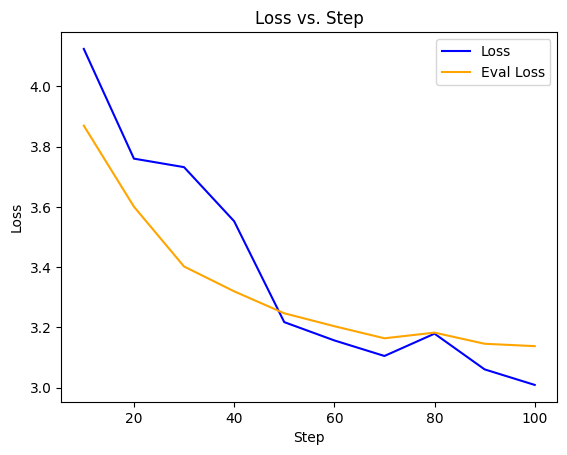

In [43]:
import matplotlib.pyplot as plt
import numpy as np
loss_values = np.array(tdf.loc[::2, 'loss'].values)
eval_loss_values = np.array(tdf.loc[1::2, 'eval_loss'].values)
steps = np.array(tdf.loc[::2, 'step'].values)

# Plot the data
plt.plot(steps, loss_values, color='blue', label='Loss')
plt.plot(steps, eval_loss_values,color='orange', label='Eval Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.savefig('Gemma PreTraining History')
plt.title('Loss vs. Step')
plt.legend()
plt.show()